# IMT FILA3 DS Apprentissage par renforcement 

### Auteurs

JALLAIS Adrien

### Date

3 Février 2023

### Objectifs

Dans ce notebook, une classe sera implémentée pour modéliser l'environnement du **Jeu des Allumettes**, avec deux joueurs : 
1. Un premier joueur représentant notre IA,
2. Un second joueur représentant un adversaire qui jouera aléatoirement

Après cette implémentation, il sera utilisée la méthode du *Q-learning*, pour permettre à cet apprentissage d'apprendre par expérimentation.

## Gérer les imports

In [1]:
import gym
from gym import spaces
from gym.utils.env_checker import check_env
import matplotlib.pyplot as plt
import numpy as np
from bucket_env import plot_stats, testing
from tqdm import tqdm
%matplotlib inline

pygame 2.1.2 (SDL 2.0.18, Python 3.10.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Définition de l'environnement
Pour créer l'environnement, nous allons implémenter la classe `Allumettes` qui héritera de `gym.Env`

In [2]:
class AllumettesEnv(gym.Env):
    #Définition de l'environnement et l'initialisation des attributs de la classe
    def __init__(self, N=15):
        #Nombre total d'allumettes initial
        self.N = N 
        #Nombre d'allumettes restantes
        self.current_nb_alu = self.N 

        #Définition de l'espace d'actions avec la méthode spaces de gym
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Discrete(self.N+1) # on veut qu'il aille de 1 à 13 (=14-1)

        self.reward = 0
        self.done = False

    #Le reset permet de réinitialiser l'environnement, en renvoyant l'observation initiale et les informations d'observation
    def reset(self):
        self.reward = 0
        self.done = False
        self.current_nb_alu = self.N
        return self.current_nb_alu
    
    def isValidAction(self, action):
        return (self.current_nb_alu - action > 1)

    #La fonction step permet de faire une action et de retourner l'état suivant
    #la récompense et un booléen qui indique si l'état est terminal ou non
    #dans une step on a deux actions réalisées : une qui est définit par note algo et une autre de manière aléatoire (pour mimer l'action de l'humain)
    def step(self, action):            
        #Player 1
        if(self.isValidAction(action)):
            #print("Player 1 : ", action)
            self.current_nb_alu -= action
            self.reward = 1
            self.done = False
        else:
            self.done=True
            self.reward = -1

        #Player 2 (tirage aléatoire)
        action = np.random.randint(1,4)
        if(not self.done and self.isValidAction(action)):
            #print("Player 2 : ", action)
            self.current_nb_alu -= action
            self.done = False
        else:
            self.done=True

        return self.current_nb_alu, self.reward, self.done, {}

## On vérifie l'environnement

Vérifie si l'environnement est bien défini par rapport à ce que gym.Env attend

In [3]:
env = AllumettesEnv()
print(f"Observation space shape: {env.observation_space.n}")
print(f"Number of actions: {env.action_space.n}")
check_env(env)

Observation space shape: 16
Number of actions: 3


## Definition de la table de valeurs $Q(s, a)$
Cette table doit permettre de lier chaque état à une action.
Pour cela, on utilise la librairie `numpy` pour créer un tableau avec une forme (*shape*) correspondant à cette paire.
La forme attendu est donnée par un tuple.

In [4]:
action_values = np.zeros((env.N+1,4))

## Définition des politiques

#### Création de la politique *cible* $\pi(s)$
Celle-ci se base uniquement sur la table de valeurs, elle fait **uniquement** de l'intensification. Il n'est donc pas nécessaire de disposer du paramètre $\epsilon$.

In [5]:
def target_policy(state):
    av = action_values[state]
    return np.random.choice(np.flatnonzero(av == av.max()))

#### Création de la politique *exploratoire* $b(s)$
A l'inverse, cette politique est purement aléatoire, elle fait **uniquement** de l'exploration. Là encore, il n'est pas nécessaire de disposer du paramètre $\epsilon$.

In [6]:
def exploratory_policy(state):
    return np.random.randint(3)

## Implementation de l'algorithme

</br>

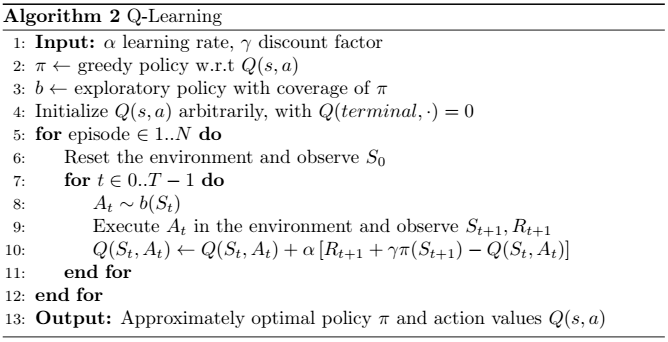
</br>
<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>



In [7]:
def q_learning(exploratory_policy, target_policy, action_values,episodes, alpha=0.1, gamma=0.99):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes+1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = exploratory_policy(state)
            next_state, reward, done, _ = env.step(action)
            ep_return += reward
            next_action = target_policy(next_state) if not done else None
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action] if not done else 0.
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
        stats['Returns'].append(ep_return)
    return stats

In [8]:
stats = q_learning(exploratory_policy, target_policy, action_values, episodes=10000)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9859.32it/s]


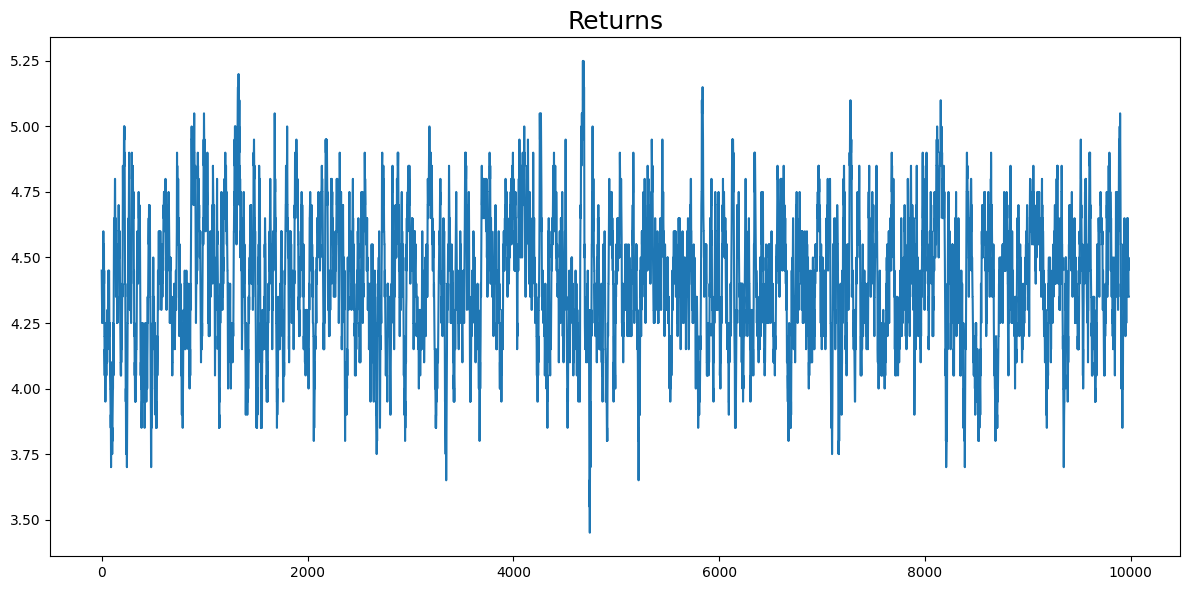

In [9]:
plot_stats(stats)

## Interprétation 

Le graphique ci-dessus, montre les itérations (sur l'axe des abscisses) de l'apprentissage de l'IA.
On observe que le nombre de tour réalisés par itérations (sur l'axe des ordonnées) ne dépasse pas 5,25, ce qui signifie que lorsque l'IA gagne, elle le fait en moins de 6 tours.

## Discussions
Un test avec un nombre initial d'allumettes `N=100`, a également été réalisée. On observe que l'IA le gagne en 34 tours environ.

## Test sur une fois

In [ ]:
testing(env, action_values)